In [21]:
from pytrade_env.utils import get_time_now

get_time_now(is_local=False)

'2018-02-01 05:20:02'

In [2]:
df = pd.read_json("https://poloniex.com/public?command=return24hVolume")
pairs = [pair for pair in df.columns if pair.startswith('USD')]

In [10]:
import pickle
filepath = "/home/tomoaki/work/pytrade_env/pytrade_env/data/ticker1.pkl"
file = open(filepath, "rb")
tickers = pickle.load(file)

In [11]:
from pytrade_env.utils import symbol_dict
for ticker in tickers:
    if ticker not in symbol_dict:
        print(ticker)

In [1]:
import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm
from urllib.request import urlopen
import json
from collections import defaultdict
from copy import deepcopy

from pytrade_env.utils import date2seconds, seconds2datetime, get_time_now, symbol_kraken2polo


Time2Seconds = {"1m": 60, "5m": 300, "15m": 900, "30m": 1800, "1h": 3600,
                "3h": 3600 * 3, "6h": 3600 * 6, "12h": 3600 * 12,
                "1D": 3600 * 24, "7D": 3600 * 24 * 7}


def get_data(ticker, start, end=None, period=30, exchange="kraken"):
    # We do not want to include start time
    start_sc = date2seconds(start) + 1
    if end is None:
        end = get_time_now()
    end_sc = date2seconds(end)
    print(start_sc, end_sc)
    print(start, end)
    if exchange == "polo":
        base_url = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d"
        url = base_url % (ticker, start_sc, end_sc, period)
        df = pd.read_json(url)
    elif exchange == "bitfx":
        base_url = "https://api.bitfinex.com/v2/candles/trade:%s:%s/hist?start=%d&end=%d"
        limit = 120
        period_sc = Time2Seconds[period]
        step = period_sc * limit
        ends_sc = np.arange(end_sc, start_sc, -step)
        dfs = []
        for _end_sc in tqdm(ends_sc):
            _start_sc = max(start_sc, _end_sc - step)
            url = base_url % (period, ticker, int(_start_sc * 1000), int(_end_sc * 1000))
            while True:
                try:
                    df = pd.read_json(url)
                    break
                except Exception as e:
                    print(e)
                    if int(e.status) == 429:
                        print('hit rate limit, sleeping for a minute...')
                        sleep(60)
            if len(df) == 0:
                break
            else:
                df = _preprocess_bitfx(df)
                dfs.append(df)
                # You can hit ~ 20 time each minute
                sleep(3)
        if dfs:
            df = pd.concat(dfs)
        else:
            df = pd.DataFrame(dfs)
    elif exchange == "kraken":
        base_url = "https://api.kraken.com/0/public/OHLC?pair=%s&interval=%d&since=%s"
        url = base_url % (ticker, period, start_sc)
        while True:
            try:
                res = urlopen(url)
                res = json.loads(res.read())
                data = res["result"][ticker]
                break
            except Exception as e:
                print(e)
                print(res)
                if res["error"][0] == 'EService:Unavailable':
                    print('Failed! Try again')
                    sleep(6)
        df = _preprocess_kraken(data)
        _start_sc = data[0][0]
        period_sc = period * 60
        if start_sc <= _start_sc - period_sc and ticker in symbol_kraken2polo:
            _start_sc -= 1
            base_url = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d"
            _ticker = symbol_kraken2polo[ticker]
            url = base_url % (_ticker, start_sc, _start_sc, period_sc)
            polo_df = pd.read_json(url)
            # Price
            ohlc_df = df[["open", "high", "low", "close"]]
            polo_ohlc_df = polo_df[["open", "high", "low", "close"]]
            price_ratio = ohlc_df["open"].values[0] / polo_ohlc_df["close"].values[-1]
            polo_ohlc_df *= price_ratio
            ohlc_df = pd.concat([polo_ohlc_df, ohlc_df])
            # Volume
            volume_df = df[["volume"]]
            polo_volume_df = polo_df[["volume"]]
            volume_ratio = volume_df.values[0][0] / polo_volume_df.values[-1][0]
            polo_volume_df *= volume_ratio
            volume_df = pd.concat([polo_volume_df, volume_df])
            # Date
            date_df = pd.concat([polo_df[["date"]], df[["date"]]])
            df = pd.concat([date_df, ohlc_df, volume_df], axis=1)
            df = df.reset_index()
    else:
        raise NotImplementedError()
    return df


def _preprocess_bitfx(df):
    date = [seconds2datetime(x / 1000) for x in df[0].values]
    df_dict = dict(date=date,
                   open=df[1].values,
                   close=df[2].values,
                   high=df[3].values,
                   low=df[4].values,
                   volume=df[5].values)
    df = pd.DataFrame(df_dict)
    return df

def _preprocess_kraken(data):
    columns = ["date", "open", "high", "low", "close", "vwap", "volume", "count"]
    new_data = defaultdict(list)
    data = deepcopy(data)
    for x in  data:
        for i, col in enumerate(columns):
            if i == 0:
                x[i] = seconds2datetime(x[i])
            else:
                x[i] = float(x[i])
            new_data[col].append(x[i])
    df = pd.DataFrame(new_data)
    return df

In [2]:
start = "2016-01-21 00:00:00"
end = get_time_now()
ticker = 'BCHUSD'

df = get_data(ticker, start, end, period=30)

1453334401.0 1517553590.0
2016-01-21 00:00:00 2018-02-02 06:39:50


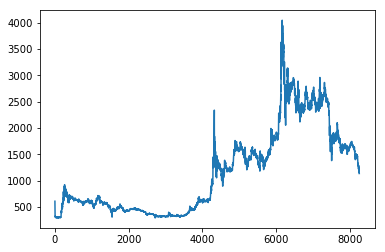

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
df["open"].plot()

In [156]:
df = pd.read_json("https://poloniex.com/public?command=return24hVolume")
pairs = [pair for pair in df.columns if pair.startswith('USD')]
pairs

['USDT_BCH',
 'USDT_BTC',
 'USDT_DASH',
 'USDT_ETC',
 'USDT_ETH',
 'USDT_LTC',
 'USDT_NXT',
 'USDT_REP',
 'USDT_STR',
 'USDT_XMR',
 'USDT_XRP',
 'USDT_ZEC']

In [9]:
from urllib.request import urlopen
import json

url = "https://api.kraken.com/0/public/AssetPairs"
res = urlopen(url)
res = json.loads(res.read())
tickers = list(res["result"].keys())
tickers = [ticker for ticker in tickers if ticker.endswith("USD")]
print(tickers)

['BCHUSD', 'DASHUSD', 'USDTZUSD', 'XETCZUSD', 'XETHZUSD', 'XLTCZUSD', 'XXBTZUSD', 'XXMRZUSD', 'XXRPZUSD', 'XZECZUSD']


In [14]:
info_dict = dict()
for key, val in res["result"].items():
    if key.endswith("USD"):
        info_dict[key] = val["altname"]

In [15]:
info_dict

{'BCHUSD': 'BCHUSD',
 'DASHUSD': 'DASHUSD',
 'USDTZUSD': 'USDTUSD',
 'XETCZUSD': 'ETCUSD',
 'XETHZUSD': 'ETHUSD',
 'XLTCZUSD': 'LTCUSD',
 'XXBTZUSD': 'XBTUSD',
 'XXMRZUSD': 'XMRUSD',
 'XXRPZUSD': 'XRPUSD',
 'XZECZUSD': 'ZECUSD'}

In [1]:
from pytrade_env.database.utils import get_data

ticker = 'USDT_BCH'
period = 1800
start = "2017-09-15 00:00:00"
end = None

df = get_data(ticker, start, end, period, exchange="polo")

In [2]:
from pytrade_env.utils import date2seconds, seconds2datetime
from datetime import timezone, datetime


x = seconds2datetime(date2seconds(start))

In [4]:
"USD".endwith("USD")

AttributeError: 'str' object has no attribute 'endwith'

In [17]:
x.second

0

In [6]:
import requests

url = "https://api.bitfinex.com/v2/symbols"
response = requests.request("GET", url)
response.text

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="utf-8">\n<title>Error</title>\n</head>\n<body>\n<pre>Cannot GET /api/v2/symbols</pre>\n</body>\n</html>\n'

In [8]:
from pytrade_env.utils import date2seconds, seconds2date
import pandas as pd

def get_data(symbol, start, end=None, period=1800):
    start_sc = date2seconds(start)
    if end is None:
        end_sc = 9999999999
    else:
        end_sc = date2seconds(end)
    url = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d"\
        % (symbol, start_sc, end_sc, period)
    return pd.read_json(url)

In [18]:
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from tqdm import tqdm


from pytrade_env.database.config import URL
from pytrade_env.database.sql_declarative import Price30M, Base
from pytrade_env.database.utils import seconds2datetime


DATA_DIR = "/home/tomoaki/work/Development/cryptocurrency/data"


def store(session, ticker, date, open, high, low, close,
          weightedAverage, volume, quoteVolume):
    obj = Price30M(ticker=ticker, date=date, open=open, high=high,
                   low=low, close=close, weightedAverage=weightedAverage,
                   volume=volume, quoteVolume=quoteVolume)
    session.add(obj)
    session.commit()


def store_csv(data_dir=DATA_DIR, currency_type='USD'):
    # Establish connection
    engine = create_engine(URL)
    Base.metadata.bind = engine
    DBSession = sessionmaker(bind=engine)
    session = DBSession()
    filenames = os.listdir(data_dir)
    for name in filenames:
        if '.csv' in name and name.startswith(currency_type):
            filepath = os.path.join(data_dir, name)
            df = pd.read_csv(filepath)
            ticker = name.split('.')[0]
            df_val = df.values
            for val in tqdm(df_val):
                data = dict(session=session,
                            ticker=ticker)
                for i, col in enumerate(df.columns):
                    if col == 'date':
                        data[col] = seconds2datetime(val[i])
                    else:
                        data[col] = val[i]
                store(**data)
    session.close()
    
    
def store_df(ticker, df):
    # Establish connection
    engine = create_engine(URL)
    Base.metadata.bind = engine
    DBSession = sessionmaker(bind=engine)
    session = DBSession()
    df_val = df.values
    for val in tqdm(df_val):
        data = dict(session=session, ticker=ticker)
        for i, col in enumerate(df.columns):
            data[col] = val[i]
        store(**data)
    session.close()

In [19]:
store_df('USDT_BCH', df)

  0%|          | 0/7018 [00:00<?, ?it/s]/home/tomoaki/anaconda3/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py:1546: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')
100%|██████████| 7018/7018 [00:24<00:00, 283.64it/s]


In [12]:
symbol = 'USDT_BCH'
start = "2017-09-08 00:00:00"
end = "2018-01-20 00:00:00"
end = None
df = get_data(symbol, start, end)

In [1]:
from tqdm import tqdm
import pandas as pd

from rltensor.environments.utils import get_data


df = pd.read_json("https://poloniex.com/public?command=return24hVolume")
pairs = [pair for pair in df.columns if pair.startswith('BTC')]
pairs = [pair for pair in df.columns]
print(pairs)

start = '2014-11-01 00:00:00'
# end = '2016-09-07 04:00:00'
end = '2016-10-28 08:00:00'

dfs = []
data_dir = "data"
for pair in tqdm(pairs):
    dfs.append(get_data(pair, data_dir, start, end))

  0%|          | 0/104 [00:00<?, ?it/s]

['BTC_AMP', 'BTC_ARDR', 'BTC_BCH', 'BTC_BCN', 'BTC_BCY', 'BTC_BELA', 'BTC_BLK', 'BTC_BTCD', 'BTC_BTM', 'BTC_BTS', 'BTC_BURST', 'BTC_CLAM', 'BTC_CVC', 'BTC_DASH', 'BTC_DCR', 'BTC_DGB', 'BTC_DOGE', 'BTC_EMC2', 'BTC_ETC', 'BTC_ETH', 'BTC_EXP', 'BTC_FCT', 'BTC_FLDC', 'BTC_FLO', 'BTC_GAME', 'BTC_GAS', 'BTC_GNO', 'BTC_GNT', 'BTC_GRC', 'BTC_HUC', 'BTC_LBC', 'BTC_LSK', 'BTC_LTC', 'BTC_MAID', 'BTC_NAV', 'BTC_NEOS', 'BTC_NMC', 'BTC_NXC', 'BTC_NXT', 'BTC_OMG', 'BTC_OMNI', 'BTC_PASC', 'BTC_PINK', 'BTC_POT', 'BTC_PPC', 'BTC_RADS', 'BTC_REP', 'BTC_RIC', 'BTC_SBD', 'BTC_SC', 'BTC_STEEM', 'BTC_STORJ', 'BTC_STR', 'BTC_STRAT', 'BTC_SYS', 'BTC_VIA', 'BTC_VRC', 'BTC_VTC', 'BTC_XBC', 'BTC_XCP', 'BTC_XEM', 'BTC_XMR', 'BTC_XPM', 'BTC_XRP', 'BTC_XVC', 'BTC_ZEC', 'BTC_ZRX', 'ETH_BCH', 'ETH_CVC', 'ETH_ETC', 'ETH_GAS', 'ETH_GNO', 'ETH_GNT', 'ETH_LSK', 'ETH_OMG', 'ETH_REP', 'ETH_STEEM', 'ETH_ZEC', 'ETH_ZRX', 'USDT_BCH', 'USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_NXT', 'USDT_REP', 'USDT_STR

KeyboardInterrupt: 

In [130]:
from dateutil import tz

from_zone = tz.tzutc()
to_zone = tz.tzlocal()

# utc = datetime.utcnow()
utc = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')

# Tell the datetime object that it's in UTC time zone since 
# datetime objects are 'naive' by default
utc = utc.replace(tzinfo=from_zone)

# Convert time zone
central = x.astimezone(to_zone)
print(from_zone)
print(to_zone)

tzutc()
tzlocal()


In [138]:
central.now()

datetime.datetime(2018, 1, 11, 17, 17, 25, 367486)

In [132]:
print(x)
print(central)

2018-01-11 22:15:15.709367
2018-01-11 22:15:15.709367-05:00


In [128]:
from datetime import datetime
x = datetime.utcnow()

In [10]:
from dateutil import tz
from datetime import datetime

def date2str(date):
    str_date = '%04d-%02d-%02d %02d:%02d:%02d' %\
        (date.year, date.month, date.day, date.hour, date.minute, date.second)
    return str_date

def get_time_now(is_local=True):
    date = datetime.utcnow()
    if is_local:
        to_zone = tz.tzlocal()
        # Convert time zone
        date = date.astimezone(to_zone)
        date = date.now()
    return date2str(date)

In [5]:
x = "USD"

In [7]:
x.endswith("USD")

True

In [11]:
get_time_now()

'2018-01-14 12:56:03'

In [13]:
from tqdm import tqdm
import pandas as pd

from rltensor.environments.utils import get_data


df = pd.read_json("https://poloniex.com/public?command=return24hVolume")
pairs = [pair for pair in df.columns if pair.startswith('BTC')]
# pairs = [pair for pair in df.columns]
print(pairs)

start = '2008-01-01 00:00:00'
# end = '2016-09-07 04:00:00'
end = '2016-10-28 08:00:00'
end = get_time_now()

dfs = []
data_dir = "data"
for pair in tqdm(pairs):
    dfs.append(get_data(pair, data_dir, start, end))


  0%|          | 0/67 [00:00<?, ?it/s]

['BTC_AMP', 'BTC_ARDR', 'BTC_BCH', 'BTC_BCN', 'BTC_BCY', 'BTC_BELA', 'BTC_BLK', 'BTC_BTCD', 'BTC_BTM', 'BTC_BTS', 'BTC_BURST', 'BTC_CLAM', 'BTC_CVC', 'BTC_DASH', 'BTC_DCR', 'BTC_DGB', 'BTC_DOGE', 'BTC_EMC2', 'BTC_ETC', 'BTC_ETH', 'BTC_EXP', 'BTC_FCT', 'BTC_FLDC', 'BTC_FLO', 'BTC_GAME', 'BTC_GAS', 'BTC_GNO', 'BTC_GNT', 'BTC_GRC', 'BTC_HUC', 'BTC_LBC', 'BTC_LSK', 'BTC_LTC', 'BTC_MAID', 'BTC_NAV', 'BTC_NEOS', 'BTC_NMC', 'BTC_NXC', 'BTC_NXT', 'BTC_OMG', 'BTC_OMNI', 'BTC_PASC', 'BTC_PINK', 'BTC_POT', 'BTC_PPC', 'BTC_RADS', 'BTC_REP', 'BTC_RIC', 'BTC_SBD', 'BTC_SC', 'BTC_STEEM', 'BTC_STORJ', 'BTC_STR', 'BTC_STRAT', 'BTC_SYS', 'BTC_VIA', 'BTC_VRC', 'BTC_VTC', 'BTC_XBC', 'BTC_XCP', 'BTC_XEM', 'BTC_XMR', 'BTC_XPM', 'BTC_XRP', 'BTC_XVC', 'BTC_ZEC', 'BTC_ZRX']
Get BTC_AMP from 1199163600 to 1515957402 with period 1800


KeyboardInterrupt: 

In [142]:
def get_data(pair, start, end, period=1800):
    datafile = os.path.join(data_dir, pair + ".csv")
    timefile = os.path.join(data_dir, pair)

    start_sec = date2seconds(start)
    end_sec = date2seconds(end)

    FETCH_URL = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d"
    COLUMNS = ["date", "high", "low", "open",
               "close", "volume", "quoteVolume", "weightedAverage"]

    url = FETCH_URL % (pair, start_sec, end_sec, period)
    print("Get %s from %d to %d with period %d" % (pair, start_sec, end_sec, period))

    df = pd.read_json(url, convert_dates=False)
    return df

In [143]:
import os
import pickle
import numpy as np

from rltensor.environments.utils import date2seconds, seconds2date


def update_data(log_dir='./data', filename='logs.pkl', default_st='2011-01-01 00:00:00', is_all=False):
    # Check the previous results
    try:
        names = os.listdir(log_dir)
    except:
        os.mkdir(log_dir)
        names = []
    if filename in names and not is_all:
        path = os.path.join(log_dir, filename)
        with open(path, 'rb') as f:
            logs = pickle.load(f)
    else:
        logs = {}
    
    df = pd.read_json("https://poloniex.com/public?command=return24hVolume")
    # pairs = [pair for pair in df.columns if pair.startswith('BTC')]
    pairs = ['USDT_BTC']
    for pair in pairs:
        if pair in logs:
            start = logs[pair]['start']
            end = logs[pair]['end']
        else:
            start = default_st
            end = default_st
            
        current_time = get_time_now()
        df = get_data(pair, end, current_time)
        # Record results
        if pair in logs:
            result = logs[pair]
        else:
            result=dict(start=None, end=None)
        if df["date"].iloc[-1] == 0:
            print("No data.")
            result['status'] = False
        else:
            result['status'] = True
            result['start'] = seconds2date(np.min(df['date'].values))
            result['end'] = seconds2date(np.max(df['date'].values))
        logs[pair] = result
    # Save the result
    path = os.path.join(log_dir, filename)
    with open(path, 'wb') as f:
        pickle.dump(logs, f, pickle.HIGHEST_PROTOCOL)

In [144]:
update_data(is_all=True)

Get USDT_BTC from 1293858000 to 1515709536 with period 1800
              close        date          high           low          open  \
0        225.000000  1424372400      0.330000    225.000000      0.330000   
1        225.000000  1424374200    225.000000    225.000000    225.000000   
2        240.000000  1424376000    240.000000    225.000000    225.000000   
3        244.000000  1424377800    244.000000    244.000000    244.000000   
4        244.000000  1424379600    244.000000    244.000000    244.000000   
5        244.000000  1424381400    244.000000    244.000000    244.000000   
6        244.000000  1424383200    244.000000    244.000000    244.000000   
7        244.000000  1424385000    244.000000    244.000000    244.000000   
8        244.000000  1424386800    244.000000    244.000000    244.000000   
9        244.000000  1424388600    244.000000    244.000000    244.000000   
10       244.000000  1424390400    244.000000    244.000000    244.000000   
11       244.000

In [116]:
df.columns
pairs = [pair for pair in df.columns if pair.startswith('USD')]
pairs

['USDT_BCH',
 'USDT_BTC',
 'USDT_DASH',
 'USDT_ETC',
 'USDT_ETH',
 'USDT_LTC',
 'USDT_NXT',
 'USDT_REP',
 'USDT_STR',
 'USDT_XMR',
 'USDT_XRP',
 'USDT_ZEC']

In [42]:
df = pd.read_json("https://poloniex.com/public?command=return24hVolume")

In [86]:
seconds2date(date2seconds(get_time_now()))

'2018-01-11 21:37:06'

In [94]:
from poloniex import Poloniex
from time import time
polo = Poloniex()
# this should give you all the historical candle data for BTC_LTC market in 24hr candles
x = polo.returnChartData('BTC_LTC', period=1800, start=date2seconds('2011-01-01 00:00:00'))

In [ ]:
with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [17]:
test = ['a', 'b']
dict((s, 0) for s in test)

{'a': 0, 'b': 0}

In [5]:
import ccxt 

ccxt.exchanges

['_1broker',
 '_1btcxe',
 'anxpro',
 'binance',
 'bit2c',
 'bitbay',
 'bitcoincoid',
 'bitfinex',
 'bitfinex2',
 'bitflyer',
 'bitlish',
 'bitmarket',
 'bitmex',
 'bitso',
 'bitstamp',
 'bittrex',
 'bl3p',
 'btcchina',
 'btcexchange',
 'btcmarkets',
 'btctradeua',
 'btcturk',
 'btcx',
 'bter',
 'bxinth',
 'ccex',
 'cex',
 'chbtc',
 'chilebit',
 'coincheck',
 'coinfloor',
 'coingi',
 'coinmarketcap',
 'coinmate',
 'coinsecure',
 'coinspot',
 'cryptopia',
 'dsx',
 'exmo',
 'flowbtc',
 'foxbit',
 'fybse',
 'fybsg',
 'gatecoin',
 'gdax',
 'gemini',
 'hitbtc',
 'hitbtc2',
 'huobi',
 'itbit',
 'jubi',
 'kraken',
 'lakebtc',
 'livecoin',
 'liqui',
 'luno',
 'mercado',
 'mixcoins',
 'okcoincny',
 'okcoinusd',
 'okex',
 'paymium',
 'poloniex',
 'quadrigacx',
 'quoine',
 'southxchange',
 'surbitcoin',
 'therock',
 'urdubit',
 'vaultoro',
 'vbtc',
 'virwox',
 'xbtce',
 'yobit',
 'yunbi',
 'zaif']

In [6]:
exchange = ccxt.poloniex()

In [8]:
exchange.hasFetchOHLCV

False